In [55]:
import pandas as pd
import numpy as np

## Execution Parameters: 

In [56]:
# LABELS TYPE:
# label_type = 'da_only' 
label_type = 'da_sa'
    
# TRUE-PRED LABELS:    
# filename = '2021-03-22_01-22-44_true_pred.csv' - retrained model
# filename = '2021-03-18_02-35-03_true_pred.csv'    # v0
# filename = '2021-03-21_14-02-50_01-23_sa_true_pred.csv'
filename = '2021-03-22_01-22-44_true_pred.csv'

# 1) LOAD True_Pred_Inference data:

In [ ]:
# LOAD DATA:
BASE_FOLDER = 'models_inference_true_pred/'
# filename = '2021-03-22_01-22-44_true_pred.csv'
        
data = pd.read_csv(BASE_FOLDER+filename,sep=",",encoding="latin1").fillna(method='ffill')  
df = pd.DataFrame(data)
df

In [121]:
df_sample = df[:10]
df_sample

,Tokentrue_labels,Labeltrue_labels,Tokenpred_labels,Labelpred_labels,Sentence
0,sql,O,sql,O,1
1,download,O,download,O,1
2,the,O,the,O,1
3,test,O,test,O,1
4,poc,O,poc,O,1
5,org,O,org,O,1
6,final,O,final,O,1
7,final,O,final,O,1
8,zip,O,zip,O,1
9,file,O,file,O,1


In [58]:
filename_shrt = filename[:19]
filename_shrt
model_name = filename_shrt
filename_shrt, model_name

('2021-03-22_01-22-44', '2021-03-22_01-22-44')

## a) True_Labels: 'y_true'

In [59]:
print(df.columns)

Index(['Tokentrue_labels', 'Labeltrue_labels', 'Tokenpred_labels',
       'Labelpred_labels', 'Sentence'],
      dtype='object')


In [ ]:
df_true = df
df_true = df_true.drop(['Tokenpred_labels'], axis=1)
df_true = df_true.drop(['Labelpred_labels'], axis=1)
df_true = df_true[['Sentence', 'Tokentrue_labels', 'Labeltrue_labels']]

df_true = df_true.rename(columns={'Sentence': 'Sentence', 'Tokentrue_labels': 'Word', 'Labeltrue_labels':'Tag'})
# df_true.columns={'Sentence', 'Word', 'Tag'}
df_true

### Convert 'y_true' to list: 'tkn_lbl_true'

In [ ]:
tkn_lbl_true = df_true.values.tolist()
tkn_lbl_true[:20]

## b) Pred_Labels: 'y_pred'

In [ ]:
df_pred = df
df_pred = df_pred.drop(['Tokentrue_labels'], axis=1)
df_pred = df_pred.drop(['Labeltrue_labels'], axis=1)
df_pred = df_pred[['Sentence', 'Tokenpred_labels', 'Labelpred_labels']]
df_pred = df_pred.rename(columns={'Sentence': 'Sentence', 'Tokenpred_labels': 'Word', 'Labelpred_labels':'Tag'})
# df_pred.columns={'Sentence', 'Word', 'Tag'}
df_pred

##### SAVE Predicted Inference to file

In [63]:
PRED_FOLDER = 'models_inference_predictions/'
file_path_to_a = PRED_FOLDER+model_name+"_inference_predictions.csv"
df_pred.to_csv(file_path_to_a, sep=',',index=False)

### Convert 'y_pred' to list: 'tkn_lbl_pred'

In [ ]:
tkn_lbl_pred = df_pred.values.tolist()
tkn_lbl_pred[:150]

### Adjust labels

In [65]:
print('verify labels and adjust if necessary (uncomment and run code below)')
stop  

verify labels and adjust if necessary (uncomment and run code below)


NameError: name 'stop' is not defined

In [ ]:
#------------------------------------------------------------------------
# uncomment and run code below if tag adjustemt is neccesary
#------------------------------------------------------------------------

line = []
temp_str = []

for line in tkn_lbl_pred:
    new_line = []
    new_line.append(line[0])
    new_line.append(line[1])
    if line[2] == 'B-PROD':
        new_line.append('I-PROD')
    elif line[2] == 'I-PROD':
        new_line.append('B-PROD')
    else:
        new_line.append('O')
        
    temp_str.append(new_line)
    
tkn_lbl_pred = temp_str
tkn_lbl_pred[:150]

In [88]:
# tkn_lbl_pred[:150]

# 2) Get Classification Report METRICS at TOKEN/LABEL Level 
# (y_true vs y_pred)

In [89]:
y_pred = [] 
y_true = []

for i in tkn_lbl_pred:
    if i[2] == 'B-PROD':
        y_pred.append(0)
    elif i[2] == 'I-PROD':
        y_pred.append(1)
    else:
        y_pred.append(2)
    
for i in tkn_lbl_true:
    if i[2] == 'B-PROD':
        y_true.append(0)
    elif i[2] == 'I-PROD':
        y_true.append(1)
    else:
        y_true.append(2)
        
target_names = ['B-PROD', 'I-PROD', 'O']

In [90]:
from sklearn.metrics import classification_report

cr = classification_report(y_true, y_pred, target_names=target_names, digits=6)
print(cr)

              precision    recall  f1-score   support

      B-PROD   0.948430  0.975779  0.961910      1734
      I-PROD   0.949199  0.946065  0.947630      1817
           O   0.996265  0.994902  0.995583     32170

    accuracy                       0.991490     35721
   macro avg   0.964632  0.972249  0.968374     35721
weighted avg   0.991549  0.991490  0.991509     35721



In [91]:
# filename = '2021-03-18_02-35-03_true_pred.csv'
modelname = filename[:19]
modelname

'2021-03-22_01-22-44'

In [92]:
MODELS_FOLDER = 'models_saved/'
import os

file = os.path.join(MODELS_FOLDER, modelname+'_eval_metrics')
with open(file, "a") as writer:
    writer.write("\n\n") 
    writer.write('\n--------------------------------------------------------------')
    writer.write("\nc) TOKEN/LABEL LEVEL Evaluation Metrics: ") 
    writer.write("\n\n")  
    writer.write(cr) 

In [93]:
stop

NameError: name 'stop' is not defined

#  3) Get Full-Entities from 'y_true' and 'y_pred':

## a) Define function to Get entities from token/label list

In [95]:
# # UNIT TESTING:
# for i in tkn_lbl[:2]:
#         print(i[0])
#         print(i[1])
#         print(i[2])
#         print(i[3])

In [96]:
# # UNIT TESTING:
# for i in tkn_lbl_true[:2]:
#     if i[2] == 'I':
#         print(i[0])
#         print(i[1])
#         print(i[2])

In [97]:
def get_entities_from_token_label_list(tkn_lbl):
    prev_lbl = 'O'
    entity = ''
    entity_list = []
    sentence_entity = []
    entity_list2 = []
    space = ' '

    # tkn_lbl = [['sa', 'B-PROD']]

    for i in tkn_lbl:
        if i[2] == 'B-PROD':
            if prev_lbl == 'O' or prev_lbl == 'I-PROD':
                if entity != '':
                    entity_list.append(entity)   # append previous entity, understand it is completed
                    sentence_entity.append(i[0])
                    sentence_entity.append(entity)
                    entity_list2.append(sentence_entity)
                    sentence_entity = []
                    entity = ''

                tkn = i[1].replace('##','')
                entity = tkn
                prev_lbl = 'B-PROD'

            elif prev_lbl == 'B-PROD':
                entity_list.append(entity)   # append previous entity, understand it is completed
                sentence_entity.append(i[0])
                sentence_entity.append(entity)
                entity_list2.append(sentence_entity)
                sentence_entity = []
                entity = ''
                
                tkn = i[1].replace('##','')
                entity = tkn
                prev_lbl = 'B-PROD'         

        elif i[2] == 'I-PROD':
            if prev_lbl == 'B-PROD':
                tkn = i[1].replace('##','')
                entity = entity + space
                entity = entity + tkn
                prev_lbl = 'I-PROD'

            elif prev_lbl == 'I-PROD':
                if '##' in i[1]:
                    tkn = i[1].replace('##','')
                    entity = entity + tkn    
                    prev_lbl = 'I-PROD'
                elif '##' not in i[1]:
                    tkn = i[1].replace('##','')
                    entity = entity + space
                    entity = entity + tkn    
                    prev_lbl = 'I-PROD'
                    
            elif prev_lbl == 'O':
                if entity != '':
                    entity_list.append(entity)
                    sentence_entity.append(i[0])
                    sentence_entity.append(entity)
                    entity_list2.append(sentence_entity)
                    sentence_entity = []                    
                    entity = ''

                tkn = i[1].replace('##','')
                entity = entity + tkn 
                prev_lbl = 'I-PROD'

        elif i[2] == 'O':
            if prev_lbl == 'B-PROD' or prev_lbl == 'I-PROD':
                entity_list.append(entity)
                sentence_entity.append(i[0])
                sentence_entity.append(entity)
                entity_list2.append(sentence_entity)
                sentence_entity = []                
                entity = ''
                prev_lbl = 'O'
            elif prev_lbl == 'O':
                prev_lbl = 'O'

    if entity != '':
        entity_list.append(entity)
        sentence_entity.append(i[0])
        sentence_entity.append(entity)
        entity_list2.append(sentence_entity)
        sentence_entity = []        

    return entity_list, entity_list2

### b) Get entities from 'y_true' (True Labels): 'entity_list_true'

In [98]:
# Get Entity Listjk
entity_list_true, entity_list2_true = get_entities_from_token_label_list(tkn_lbl_true)

In [99]:
entity_list_true[:10]

['sap operational process intelligence',
 'cloud',
 'sap cloud platform',
 'business bydesign',
 'sap hana',
 'sap cloud platform',
 'cloud',
 'sap lt replication server',
 'sap fiori',
 'sap hana']

In [100]:
entity_list2_true[:10]

[[2, 'sap operational process intelligence'],
 [3, 'cloud'],
 [4, 'sap cloud platform'],
 [5, 'business bydesign'],
 [5, 'sap hana'],
 [6, 'sap cloud platform'],
 [7, 'cloud'],
 [8, 'sap lt replication server'],
 [9, 'sap fiori'],
 [10, 'sap hana']]

In [101]:
print('Total TRUE Entities: ')
print(len(entity_list_true))

Total TRUE Entities: 
1777


### c) Get entities from 'y_pred' (Predicted Labels): 'entity_list_pred'

In [102]:
tkn_lbl_pred[:20]

[[1, 'sql', 'O'],
 [1, 'download', 'O'],
 [1, 'the', 'O'],
 [1, 'test', 'O'],
 [1, 'poc', 'O'],
 [1, 'org', 'O'],
 [1, 'final', 'O'],
 [1, 'final', 'O'],
 [1, 'zip', 'O'],
 [1, 'file', 'O'],
 [1, 'after', 'O'],
 [1, 'the', 'O'],
 [1, 'script', 'O'],
 [1, 'execution', 'O'],
 [1, 'from', 'O'],
 [1, 'winscp', 'B-PROD'],
 [1, 'and', 'O'],
 [1, 'move', 'O'],
 [1, 'it', 'O'],
 [1, 'to', 'O']]

In [103]:
entity_list_pred, entity_list2_pred = get_entities_from_token_label_list(tkn_lbl_pred)
print('Total PRED Entities: ')
print(len(entity_list_pred))

Total PRED Entities: 
1807


In [104]:
# entity_list_pred[:15]

# 4) Get "SAP-Products" List: 'sap_ent_prod_lwr'

In [105]:
# -------------------------------------------------------------------------
# 1) LOAD SAP-PRODUCT_ENTITIES:
# -------------------------------------------------------------------------
PRODUCTS_FOLDER = "sap-products/"

if label_type == 'da_only': 
    sap_products_file = "prod_full_sap-L1_v2.csv"
elif label_type == 'da_sa': 
    sap_products_file = "prod_full_sap-L1_v2_inclSA_v1.csv"

sap_ent_prod =[]
fileObject = open(PRODUCTS_FOLDER+sap_products_file, "r")
sap_ent_prod = fileObject.read()
sap_ent_prod = sap_ent_prod.split('\n')
# sap_ent_prod

# Convert to lower case:
sap_ent_prod_lwr = []
for p in sap_ent_prod:
    p = p.replace('\ufeff','')
    sap_ent_prod_lwr.append(p.lower())

sap_ent_prod_lwr = sorted(set(sap_ent_prod_lwr))
  
print('SAP Products loaded: ')
print(len(sap_ent_prod_lwr))  
  
# print(sap_ent_prod_lwr)

SAP Products loaded: 
1226


# 5) Get true_positive and false_positive from 'y_pred': 'true_predicted_entities', 'false_predicted_entities'
by checking predicted entities that exist or not in the sap_product_list

In [106]:
true_predicted_entities = []
false_predicted_entities = []


for i in entity_list_pred:
    if i in sap_ent_prod_lwr:
        true_predicted_entities.append(i)
    else:
        false_predicted_entities.append(i)
        
print('Number of True Predicted Entities: ', len(true_predicted_entities))
print('Number of False Predicted Entities: ', len(false_predicted_entities))
print('Total Predicted Entities: ', len(true_predicted_entities) + len(false_predicted_entities))
print('Total True Entities: ', len(entity_list_true))

Number of True Predicted Entities:  1714
Number of False Predicted Entities:  93
Total Predicted Entities:  1807
Total True Entities:  1777


In [107]:
Accuracy = len(true_predicted_entities) / len(entity_list_true)
print('Model Accuracy: ', Accuracy)

Model Accuracy:  0.9645469893078221


In [108]:
# True positives:
TP=len(true_predicted_entities)
#False Positives:
FP=len(false_predicted_entities)
#False Negatives:
FN=len(entity_list_true)-len(true_predicted_entities)

TP, FP, FN

(1714, 93, 63)

In [109]:
# Precision= TP/(TP+FP):
precision = TP/(TP+FP)
print('Precision = ', precision)

# Recall= TP/(TP+FN)
recall = TP/(TP+FN)
print('Recall: ', recall)

# f1-score = 2 * (Precision*Recall) / (Precision + Recall)
f1 = 2 * (precision*recall) / (precision + recall)
print('f1-score: ', f1)

Precision =  0.9485334809075816
Recall:  0.9645469893078221
f1-score:  0.9564732142857143


### SAVE evaluation metrics to file:

In [110]:
file = os.path.join(MODELS_FOLDER, modelname+'_eval_metrics')
with open(file, "a") as writer:
    writer.write("\n") 
    writer.write('\n--------------------------------------------------------------')
    writer.write("\nd) FULL-ENTITY LEVEL Evaluation Metrics: ") 
    writer.write("\n")  
    writer.write('\nNumber of True Predicted Entities: ') 
    writer.write(str(len(true_predicted_entities)))
    writer.write('\nNumber of False Predicted Entities: ') 
    writer.write(str(len(false_predicted_entities)))
    writer.write('\nTotal Predicted Entities: ') 
    tot_pred_ent = str(len(true_predicted_entities) + len(false_predicted_entities))
    writer.write(tot_pred_ent)
    writer.write('\nTotal True Entities: ') 
    writer.write(str(len(entity_list_true)))
    writer.write('\nPrecision = ') 
    writer.write(str(precision))
    writer.write('\nRecall: ')
    writer.write(str(recall))
    writer.write('\nf1-score: ') 
    writer.write(str(f1))      
    writer.write('\n--------------------------------------------------------------')

In [111]:
modelname

'2021-03-22_01-22-44'

### List 'true_pred_entities' and 'false_pred_ent'

In [112]:
# true_predicted_entities = sorted(true_predicted_entities)
true_predicted_entities[:5]

['sap operational process intelligence',
 'sap cloud platform',
 'bydesign',
 'sap hana',
 'sap cloud platform']

In [113]:
# false_predicted_entities = sorted(false_predicted_entities)
false_predicted_entities[:5]

['winscp',
 'business',
 'sap business suite',
 'cloud',
 'sap predictive services']

# 6) Produce Wordcloud from True Positives and False positives:

### a) Define function:

In [114]:
!pip install wordcloud --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [115]:
def get_wordcloud_from_entity_list(entity_list,true_or_false):
    
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    import matplotlib.pyplot as plt
    
    # Entity List to String
    ents_strg = ''
    for i in entity_list:
        ent = i.replace(' ','_')
        ents_strg = ents_strg + ' ' + ent
        
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(ents_strg)
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=200, max_words=350, background_color="white").generate(ents_strg)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    # Save the image in the img folder:
    # wordcloud.to_file("wordcloud_sapner_tds_836_1.png")
    wordcloud.to_file(filename_shrt+'_'+true_or_false+"_wordcloud.png")
    
    return
    
# print(ents_strg)

### b) Get True Positive Entities Wordcloud:

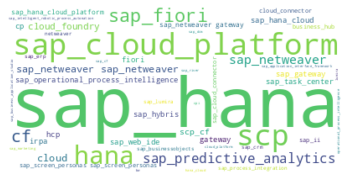

In [116]:
get_wordcloud_from_entity_list(entity_list_true,'true')

### c) Get False Positive Entities Wordcloud:

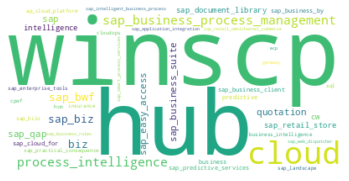

In [117]:
get_wordcloud_from_entity_list(false_predicted_entities,'false')

In [118]:
stop

NameError: name 'stop' is not defined

# 7) Get Count by Entities:

### a) Define function:

In [ ]:
def from_ent_list2_to_entity_count(ent_list):
    ent_list_df = pd.DataFrame(ent_list)
#     ent_list_df = ent_list_df.rename(columns={ent_list_df.columns[0]: 'Sentence_Token'})
    ent_list_df = ent_list_df.rename(columns={ent_list_df.columns[0]: 'Tag'})
    
    tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
    tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)

    columnsTitles = ['Tag', 'Count']
    tag_n_df = tag_n_df.reindex(columns=columnsTitles)

    tag_n_df

    return ent_list_df, tag_n_df


In [ ]:
def save_df_to_file(filename, df, sufix):
    FOLDER = 'models_inference_true_pred/'
    name = filename[:19]+'_'+sufix
    
    file_path_to_a = 'models_inference_true_pred/'+name
    df.to_csv(file_path_to_a, sep=',',index=False)

### b) Entity count from TRUE LABELS ('y_true)

In [ ]:
df_EL_TL, df_EC_TL = from_ent_list2_to_entity_count(entity_list_true)
df_EC_TL[:20]

In [ ]:
save_df_to_file(filename, df_EC_TL, 'EC_TL')

### c) Entity count from TRUE PREDICTIONS ('y_pred_true'= true_predicted_entities)

In [ ]:
df_EL_PT, df_EC_PT = from_ent_list2_to_entity_count(true_predicted_entities)
df_EC_PT[:20]

In [ ]:
save_df_to_file(filename, df_EC_PT, 'EC_PT')

### d) Entity count from FALSE PREDICTIONS ('y_pred_false'= false_predicted_entities)

In [ ]:
df_EL_PF, df_EC_PF = from_ent_list2_to_entity_count(false_predicted_entities)
df_EC_PF[:20]

In [ ]:
save_df_to_file(filename, df_EC_PF, 'EC_PF')

In [ ]:
----------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------- END OF CODE -----------------------------------------------------------------

## OLD CODE BELOW:

In [ ]:
def get_entity_type_counter(ent_list2):
    
    ent_list_df = pd.DataFrame(ent_list2)
#     ent_list_df.head()
    
    ent_list_df.columns={'Sentence_Token', 'Tag'}
#     ent_list_df
    
    ent_list_df_sap = ent_list_df[ent_list_df.Tag.str.contains("sap")]
#     ent_list_df_sap

    ent_list_df = ent_list_df_sap
    tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
    tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)
    
    columnsTitles = ['Filename', 'Tag', 'Count']
    tag_n_df = tag_n_df.reindex(columns=columnsTitles)

    
    return tag_n_df

In [ ]:
get_entity_type_counter(entity_list2_true)

In [ ]:
ent_list_sap = []

for line in entity_list2_true:
    i = line[1]
    if i[:3] == "sap":
        ent_list_sap.append(line)
        
ent_list_sap[:10]

In [ ]:
df1, df2 = from_ent_list2_to_entity_count(entity_list_true)
df1

In [ ]:
df2

In [ ]:
tag_n_df = df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)

columnsTitles = ['Tag', 'Count']
tag_n_df = tag_n_df.reindex(columns=columnsTitles)

tag_n_df

In [ ]:
ent_list_df = pd.DataFrame(ent_list_sap)
ent_list_df = ent_list_df.rename(columns={ent_list_df.columns[0]: 'Sentence_Token'})
ent_list_df = ent_list_df.rename(columns={ent_list_df.columns[1]: 'Tag'})

ent_list_df

In [ ]:
tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)

columnsTitles = ['Filename', 'Tag', 'Count']
tag_n_df = tag_n_df.reindex(columns=columnsTitles)

tag_n_df

In [ ]:
ent_list_df = pd.DataFrame(entity_list2_true)
#     ent_list_df.head()
    
ent_list_df.columns={'Sentence_Token', 'Tag'}
#     ent_list_df

ent_list_df_sap = ent_list_df[ent_list_df.Tag.str.contains("sap")]
#     ent_list_df_sap

ent_list_df = ent_list_df_sap
tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)
tag_n_df

In [ ]:
columnsTitles = {}'Filename', 'Tag', 'Count'
tag_n_df = tag_n_df.columns={columns=columnsTitles

tag_n_df

### a) Count True Entities:

In [ ]:
true_entity_count = get_entity_type_counter(entity_list2_true)

true_entity_count[:20]

#### Save to file:

In [ ]:
# SAVE TO FILE:

# filename = 
# file_path_to_a = "tagged_entities/Entity_Count_"+filename[4:]
# tag_n_df.to_csv(file_path_to_a, sep=',',index=False)

### b) Count False predicted entities:

In [ ]:
# Get false_predicted_entities2

counter = 1
false_predicted_entities2 = []

for i in false_predicted_entities:
    line=[]
    line.append(counter)
    line.append(i)
    false_predicted_entities2.append(line)
    counter = counter + 1
    
false_predicted_entities2[:5]

In [ ]:
false_entity_count = get_entity_type_counter(false_predicted_entities2)

false_entity_count[:20]

#### Save to file:

In [ ]:
# SAVE TO FILE:

# filename = 
# file_path_to_a = "tagged_entities/Entity_Count_"+filename[4:]
# tag_n_df.to_csv(file_path_to_a, sep=',',index=False)

In [ ]:
-------------- END OF CODE ---------------

## Get 'Entities per sentence' dataframe

In [ ]:
# ent_list_df = pd.DataFrame(entity_list2, columns={'Sentence', 'Tag'})
ent_list_df = pd.DataFrame(entity_list2)
# ent_list_df['Counter'] = 1
ent_list_df.head()

In [ ]:
ent_list_df.columns={'Sentence_Token', 'Tag'}
ent_list_df

In [ ]:
ent_list_df_sap = ent_list_df[ent_list_df.Tag.str.contains("sap")]
ent_list_df_sap

In [ ]:
ent_list_df

#### Save to file

In [ ]:
filename[4:]

In [ ]:
# SAVE TO FILE:
file_path_to_a = "tagged_entities/Sentce_Token_Tag_"+filename[4:]
ent_list_df.to_csv(file_path_to_a, sep=',',index=False)

## Get 'Tag counter' dataframe

In [ ]:
ent_list_df = ent_list_df_sap
tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)
tag_n_df['Filename'] = filename 
tag_n_df

In [ ]:
columnsTitles = ['Filename', 'Tag', 'Count']

tag_n_df = tag_n_df.reindex(columns=columnsTitles)
tag_n_df

#### Save to file:

In [ ]:
filename[4:]

In [ ]:
# SAVE TO FILE:
file_path_to_a = "tagged_entities/Entity_Count_"+filename[4:]
tag_n_df.to_csv(file_path_to_a, sep=',',index=False)

In [ ]:
STOP HERE

## Get Tag counter in list

In [ ]:
tag_n_l = tag_n_df.values.tolist()
tag_n_l[:5]

In [ ]:
for i in tag_n_l:
    print(i)

## Final function: 'from_bio_file_to_entities_count_df'

In [ ]:
filename = 'scw_01-23_sa_v6.csv'

In [ ]:
def from_bio_file_to_entities_count_df(base_folder, filename):
    
    import pandas as pd
    
    # Load data
    data = pd.read_csv(base_folder+filename,sep=",",encoding="latin1").fillna(method='ffill')  
    
    # move data to list object
    tkn_lbl_2 = data.values.tolist()
    
    # Get Entities list and Entities per Sentence:
    entity_list, entity_list2 = get_entities_from_token_label_list(tkn_lbl_2)
    
    # Get 'Entities per sentence' dataframe
    ent_list_df = pd.DataFrame(entity_list2, columns={'Sentence', 'Tag'})
    ent_list_df['Counter'] = 1
    
    # Get 'Tag counter' dataframe
    tag_n_df = ent_list_df.groupby( [ "Tag"] ).size().to_frame(name = 'Count').reset_index()
    tag_n_df = tag_n_df.sort_values(['Count', 'Tag'], ascending=False)
    tag_n_df['Filename'] = filename 
    # Re-order columns:
    columnsTitles = ['Filename', 'Tag', 'Count']
    tag_n_df = tag_n_df.reindex(columns=columnsTitles)
    
    # Get Tag counter in list
    tag_n_l = tag_n_df.values.tolist()
    
    
    return tag_n_l

# EXECUTION:
base_folder = 'training-datasets/'
filename = filename

entity_list_count = from_bio_file_to_entities_count_df(base_folder, filename)
entity_list_count

# b) Plot 'TAG' Groupby.count()

In [ ]:
ent_list_df[:100]

In [ ]:
df = ent_list_df.groupby(by='Tag').agg('count')
df = df.sort_values(by=['Sentence_Token'], ascending=False)
ent_count_top30_df = df.head(30)
ent_count_top30_df

In [ ]:
plt.figure(figsize=(300,200))
ent_count_top30_df.plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Entities")
plt.ylabel("Count")
plt.show()

In [ ]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image

import matplotlib.pyplot as plt
# % matplotlib inline

%matplotlib inline

In [ ]:
Tags = ent_list_df.groupby("Tag")

In [ ]:
plt.figure(figsize=(15,10))
Tags.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Country of Origin")
plt.ylabel("Number of Wines")
plt.show()

# c) Generate Entities' Word Cloud

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# Entity List to String
ents_strg = ''
for i in entity_list:
    ent = i.replace(' ','_')
    ents_strg = ents_strg + ' ' + ent
    
print(ents_strg)

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(ents_strg)

In [ ]:
# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(ents_strg)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Save the image in the img folder:
wordcloud.to_file("wordcloud_sapner_tds_836_1.png")

In [ ]:
df = pd.DataFrame(dict(A=[5,3,5,6], C=["sap hana","sap cloud platform","hana", "cloud connector"]))

In [ ]:
df

In [ ]:
df2 = df[df.C.str.contains("sap")]

In [ ]:
df2